## Import Data

In [62]:
# Import modules
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
import pandas as pd

# Set seed for reproducibility
np.random.seed(5)

# Read in data (both in same file)
shows_df = pd.read_csv('netflix_shows.csv')

# Inspect the new DataFrame
shows_df.head()

print("Number of movies loaded: %s " % (len(shows_df)))

# Display the data
shows_df.head()

Number of movies loaded: 2662 


title                                               cast  \
0          Blood & Water  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   
1              Ganglands  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...   
2  Jailbirds New Orleans                                                NaN   
3           Kota Factory  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...   
4          Midnight Mass  Kate Siegel, Zach Gilford, Hamish Linklater, H...   

         country date_added  release_year rating   duration  \
0   South Africa  24-Sep-21          2021  TV-MA  2 Seasons   
1         France  24-Sep-21          2021  TV-MA   1 Season   
2  United States  24-Sep-21          2021  TV-MA   1 Season   
3          India  24-Sep-21          2021  TV-MA  2 Seasons   
4  United States  24-Sep-21          2021  TV-MA   1 Season   

                                           listed_in  \
0    International TV Shows, TV Dramas, TV Mysteries   
1  Crime TV Shows, International TV Shows, TV Act...   
2                             Docuseries, Reality TV   
3  International TV Shows, Romantic TV Shows, TV ...   
4                 TV Dramas, TV Horror, TV Mysteries   

                                         description  
0  After crossing paths at a party, a Cape Town t...  
1  To protect his family from a powerful drug lor...  
2  Feuds, flirtations and toilet talk go down amo...  
3  In a city of coaching centers known to train I...  
4  The arrival of a charismatic young priest brin...

## Validate Dataset

In [63]:
shows_df.dtypes

title           object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

In [64]:
shows_df.isnull().sum()

title             0
cast            350
country           0
date_added        0
release_year      0
rating            0
duration          0
listed_in         0
description       0
dtype: int64

In [65]:
shows_df.duplicated().sum()

0

In [66]:
description_lengths = shows_df['description'].str.len()
description_lengths.describe()

count    2662.000000
mean      142.588279
std         9.474084
min        82.000000
25%       140.000000
50%       146.000000
75%       149.000000
max       243.000000
Name: description, dtype: float64

## Stemming & Tokenizing


In [68]:
from nltk.stem.snowball import SnowballStemmer

# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")

# Define a function to perform both stemming and tokenization
def tokenize_and_stem(text):
    
    # Tokenize by sentence, then by word
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = [stemmer.stem(t) for t in filtered_tokens]
    
    return stems

## Create TfidfVectorizer

In [99]:
# Import TfidfVectorizer to create TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(max_features=200000,
                                stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))


## Fit transform TfidfVectorizer

In [101]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

# Fit and transform the tfidf_vectorizer with the "plot" of each show
# to create a vector representation of the plot summaries
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in shows_df['description']])

print(tfidf_matrix.shape)

[nltk_data] Downloading package punkt to /home/devel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(2662, 69870)


## Import KMeans and create clusters

In [102]:
# Import k-means to perform clusters
from sklearn.cluster import KMeans

# Create a KMeans object with 5 clusters and save as km
km = KMeans(n_clusters=5)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
shows_df["cluster"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
shows_df['cluster'].value_counts() 

0    1256
1     472
4     408
3     325
2     201
Name: cluster, dtype: int64

## Calculate similarity distance

In [103]:
# Import cosine_similarity to calculate similarity of movie plots
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

## Create merging and plot dendrogram

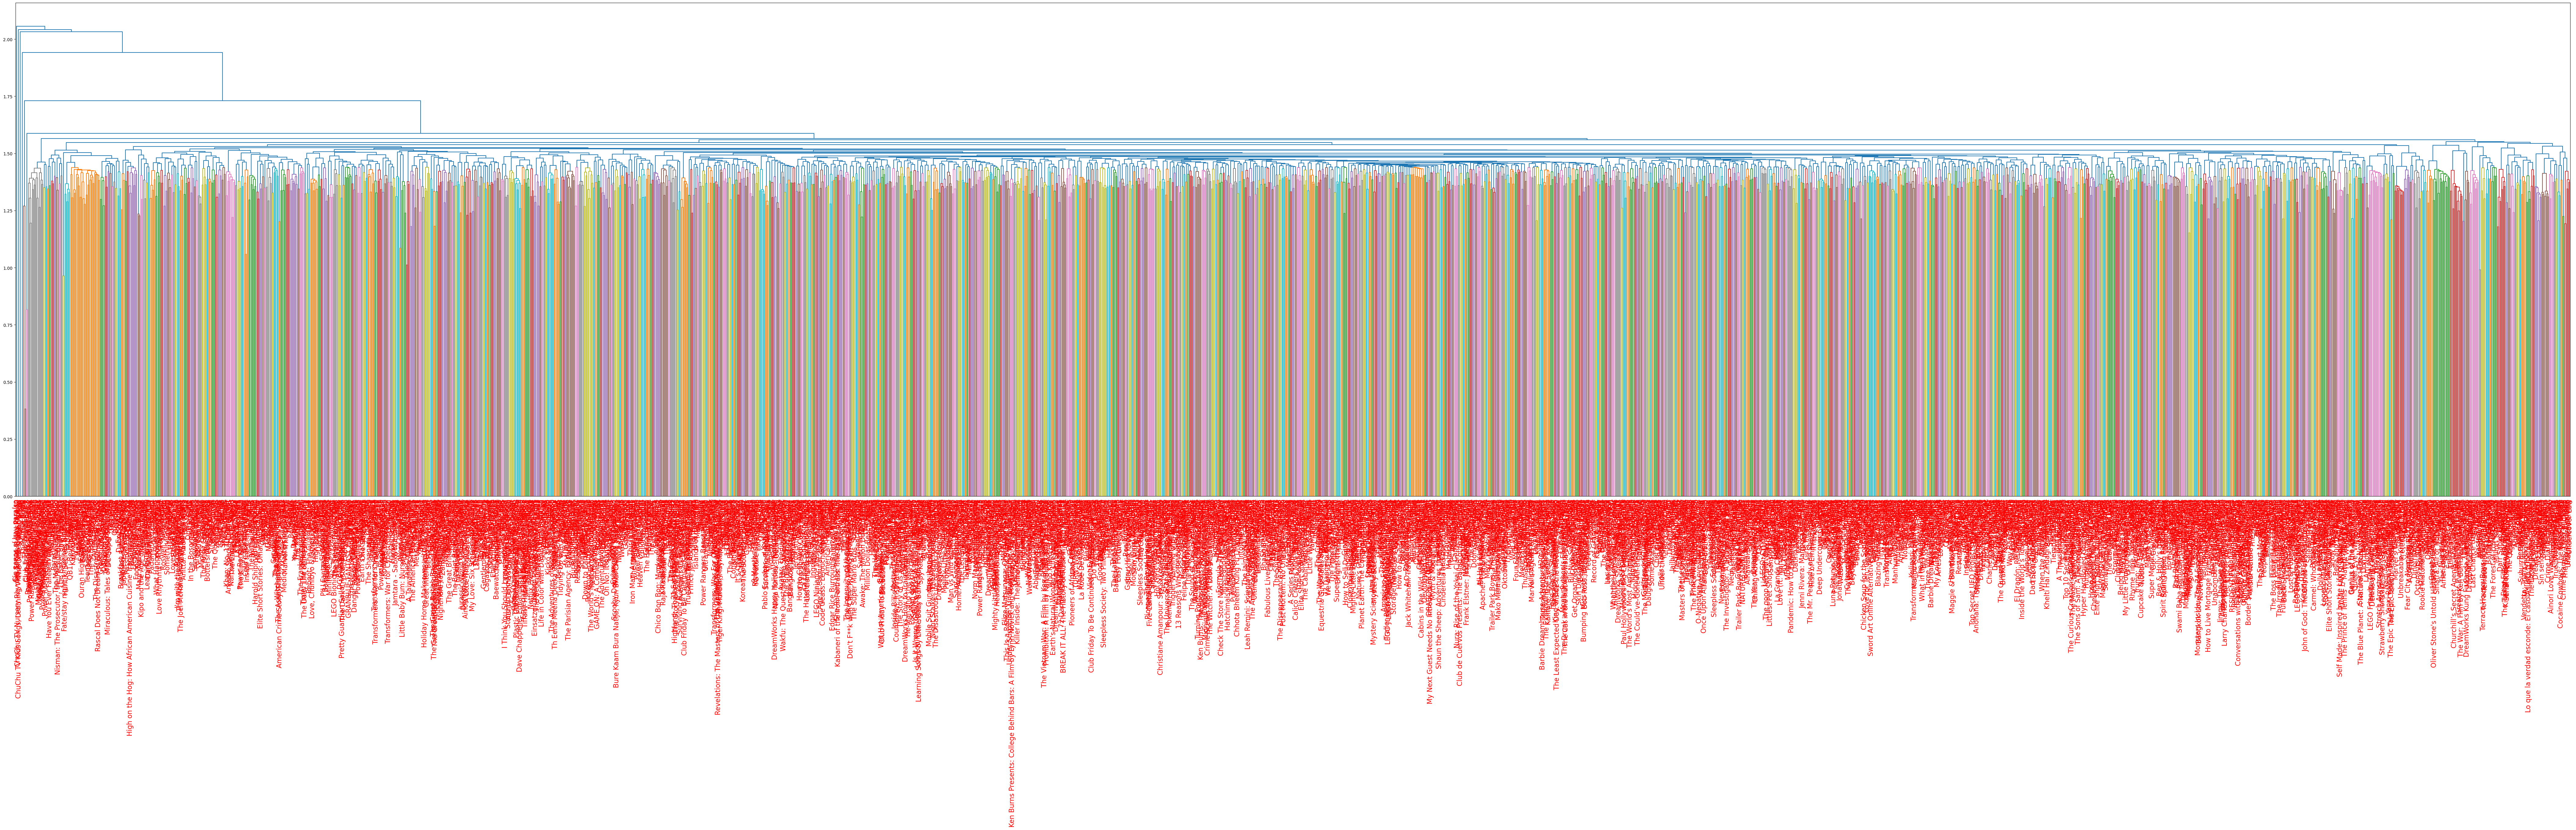

In [120]:
# Import matplotlib.pyplot for plotting graphs
import matplotlib.pyplot as plt

# Configure matplotlib to display the output inline
%matplotlib inline

# Import modules necessary to plot dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram
#########################################################

# Create mergings matrix 
mergings = linkage(similarity_distance, method='complete')


# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in shows_df["title"]],
               leaf_rotation=90,
               leaf_font_size=16)


# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

# Show the plotted dendrogram
plt.show()

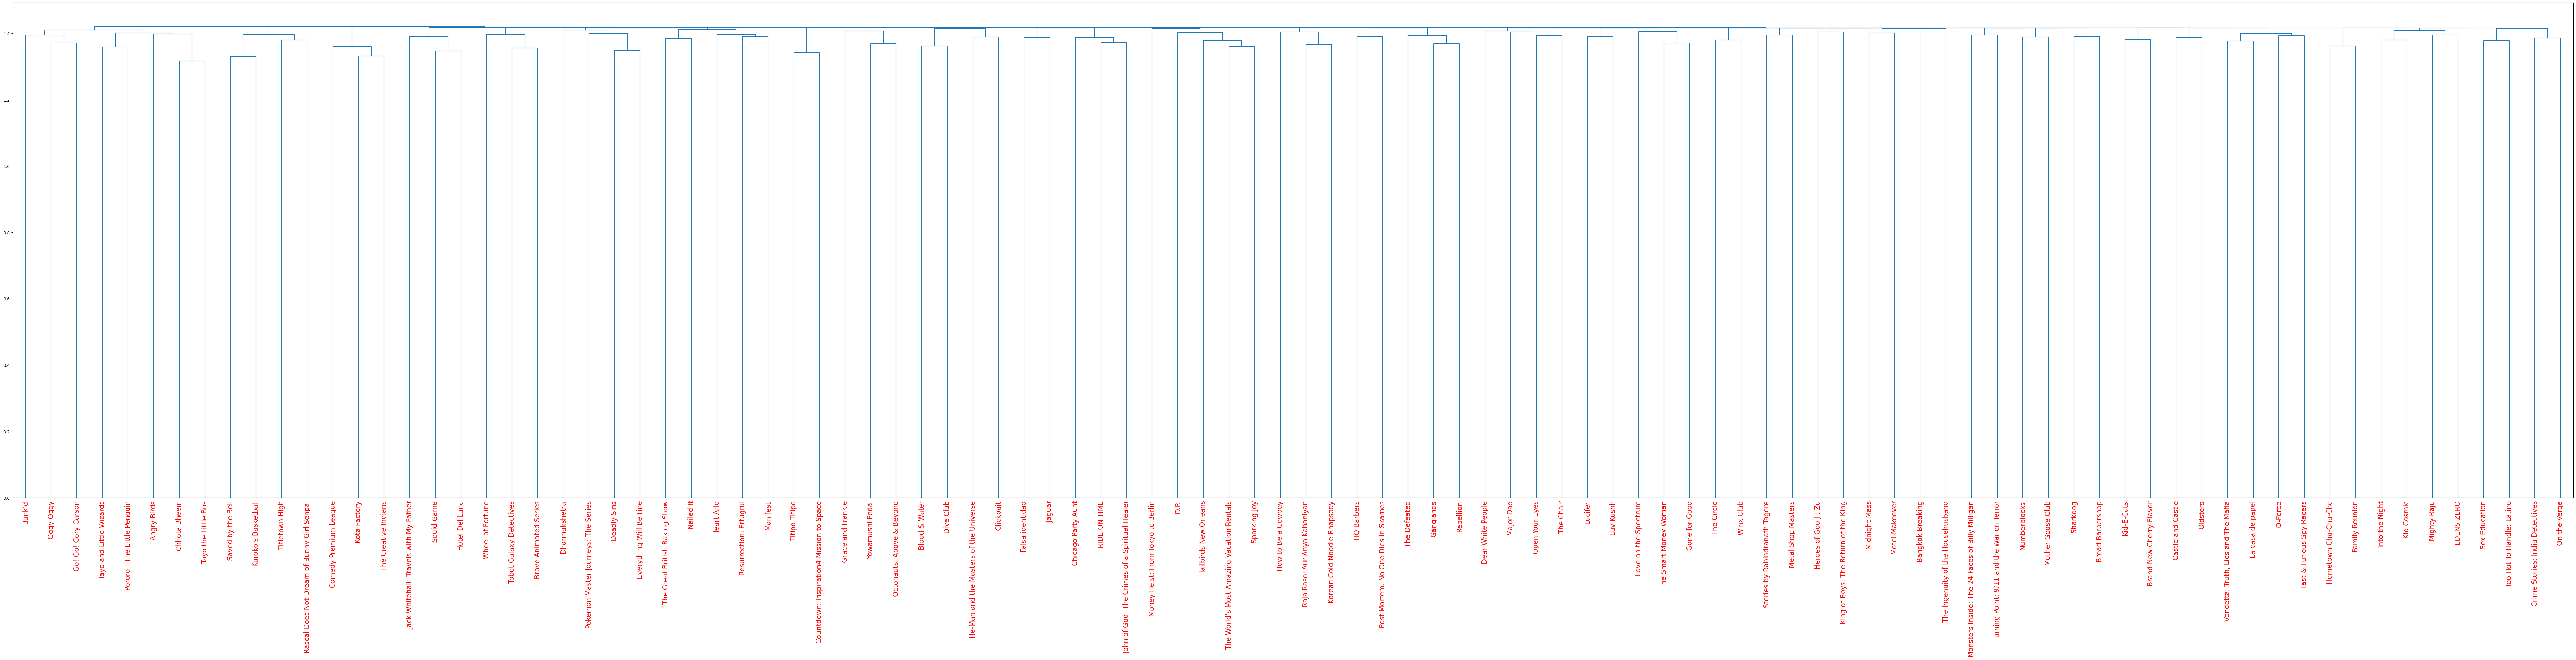

In [123]:
# Import matplotlib.pyplot for plotting graphs
import matplotlib.pyplot as plt

# Configure matplotlib to display the output inline
%matplotlib inline

# Import modules necessary to plot dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

# Select the first 100 movie titles
selected_titles = shows_df["title"].head(100)

# Create a subset of the similarity distance matrix containing only the selected titles
selected_similarity_distance = similarity_distance[:100, :100]

# Create mergings matrix 
mergings = linkage(selected_similarity_distance, method='complete')

# Plot the dendrogram, using selected titles as label column
dendrogram_ = dendrogram(mergings,
                         labels=[x for x in selected_titles],
                         leaf_rotation=90,
                         leaf_font_size=16)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

# Show the plotted dendrogram
plt.show()


## Top 20 Most Similar Shows

In [126]:
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Exclude self-similarity comparisons (do not compare a document to itself)
np.fill_diagonal(cosine_sim_matrix, 0)

# Get indices for top right of matrix (except main diagonal)
upper_triangular_indices = np.triu_indices(cosine_sim_matrix.shape[0], k=1)

# Get according similarities values generated previously
similarities_flat = cosine_sim_matrix[upper_triangular_indices]

#Sort to get top 20 most similar shows
top_20_indices = similarities_flat.argsort()[-20:][::-1]

most_similar_indices = (upper_triangular_indices[0][top_20_indices], upper_triangular_indices[1][top_20_indices])

for i, (idx1, idx2) in enumerate(zip(*most_similar_indices), 1):
    movie1_title = shows_df.iloc[idx1]["title"]
    movie2_title = shows_df.iloc[idx2]["title"]
    print(f"{i}. {movie1_title} and {movie2_title}")

1. 9-Feb and 9-Feb
2. The Ollie & Moon Show and Ollie & Moon
3. ChuChu TV Nursery Rhymes & Kids Songs (Hindi) and ChuChu TV Kids Songs, Learning Videos & Bedtime Stories
4. Sin senos sí hay paraíso and Sin Senos sí Hay Paraíso
5. The Circle and The Circle France
6. Club Friday The Series 7 and Club Friday The Series 8
7. 忍者ハットリくん and Ninja Hattori
8. Unlucky Ploy and Another Miss Oh
9. Tales of the City and Tales of the City (1993)
10. Word Party and Word Party Songs
11. Cold Case Files and Cold Case Files Classic
12. The Circle and The Circle Brazil
13. The Circle France and The Circle Brazil
14. Monty Don's French Gardens and Monty Don's Italian Gardens
15. Slasher and Goedam
16. The Great British Baking Show: The Beginnings and The Great British Baking Show: Masterclass
17. Charité at War and Charité
18. El Chapo and The Day I Met El Chapo
19. The Epic Tales of Captain Underpants in Space and The Epic Tales of Captain Underpants
20. Sing On! and Sing On! Germany
